In [25]:
import tensorflow as tf
from tensorflow.python.framework.graph_util import convert_variables_to_constants
import numpy as np
import scipy
import sys
import lucid.optvis.param as param
import lucid.optvis.render as render
from lucid.misc.io.showing import _image_url, _display_html
from lucid.modelzoo.vision_base import Model
import matplotlib.pyplot as plt
import re

%matplotlib inline

In [26]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

img_rows = x_train.shape[1]
img_cols = x_train.shape[2]

#preprocessing data
x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [27]:
x_test[0,:,:,:].shape

(1, 28, 28)

In [28]:
#guided-backprop needs to overwrite the computation of the gradients,
@tf.RegisterGradient("GuidedRelu")
def _guided_backprop(op, grad):
    dtype = op.outputs[0].dtype
    gate_g = tf.cast(grad > 0., dtype)
    gate_y = tf.cast(op.outputs[0] > 0., dtype)
    return gate_y * gate_g * grad

KeyError: "Registering two gradient with name 'GuidedRelu'! (Previous registration was in <module> /usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16)"

INFO:tensorflow:Restoring parameters from LeNet5


INFO:tensorflow:Restoring parameters from LeNet5


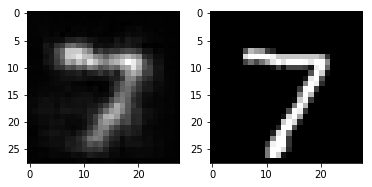

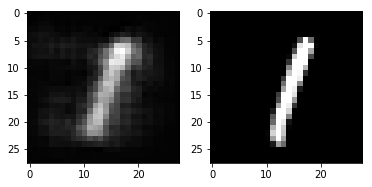

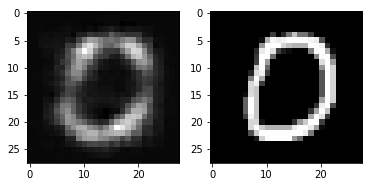

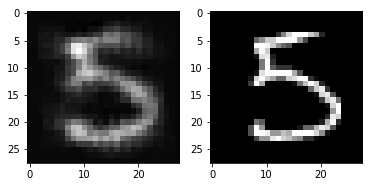

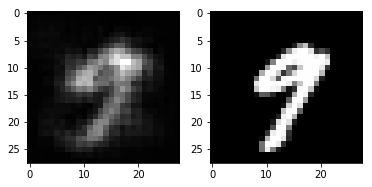

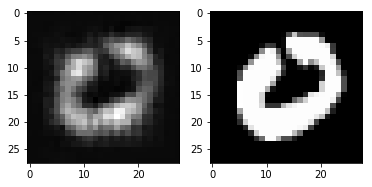

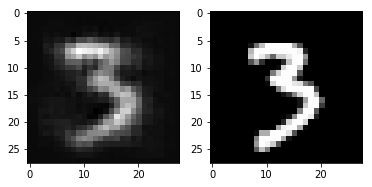

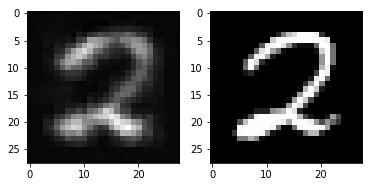

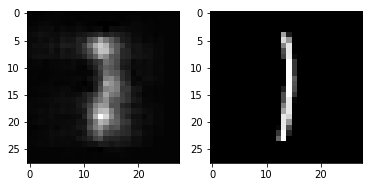

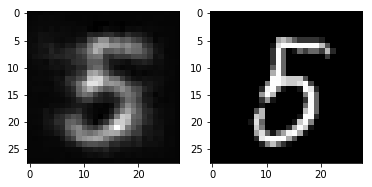

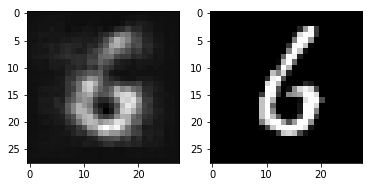

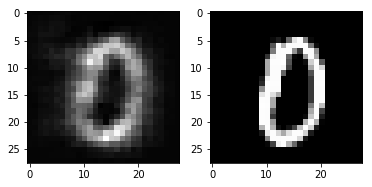

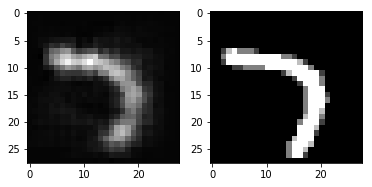

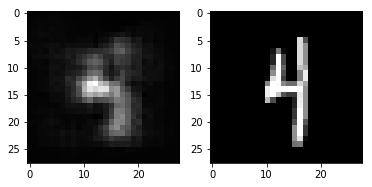

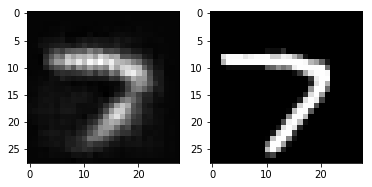

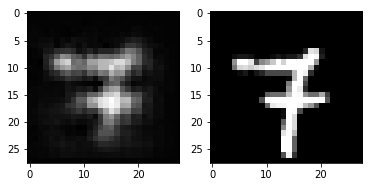

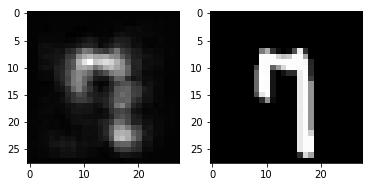

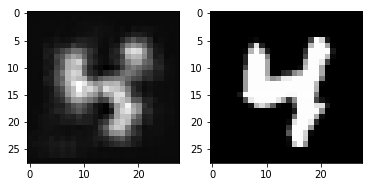

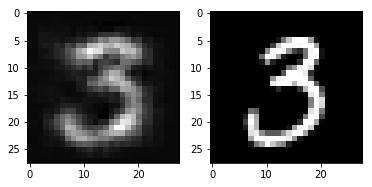

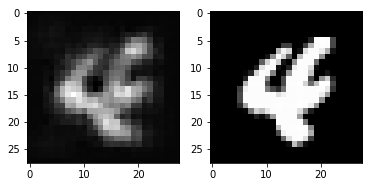

In [46]:
# and after we use it under a session:
with tf.Session() as sess:
    with sess.graph.gradient_override_map({'Relu': 'GuidedRelu'}):
        saver = tf.train.import_meta_graph("LeNet5.meta", clear_devices=True)
        saver.restore(sess, "LeNet5")
        
        ops = sess.graph.get_operations()
        # all the tensor informations
        tensors = [m.values() for m in ops]
        
        in_tensor = sess.graph.get_tensor_by_name("conv2d_input:0")
        out_tensor = sess.graph.get_tensor_by_name("dense/Relu:0")
        
        grads = tf.gradients(out_tensor, in_tensor)[0]
        
        X = x_test[0:100:5,:,:,:]
        
        act_map = sess.run(grads, feed_dict={in_tensor: X})
        
        for i in np.arange(0, X.shape[0]):
            plt.figure()
            plt.subplot(1, 2, 1)
            plt.imshow(act_map[i,0,:,:], cmap='gray')
            plt.subplot(1, 2, 2)
            plt.imshow(x_test[i*5,0,:,:], cmap='gray')

In [44]:
x_test[0:100:5,:,:,:].shape

(20, 1, 28, 28)

In [ ]:
def save_frozen_graph(filename, output_channels):
    output_graph_def = tf.graph_util.convert_variables_to_constants(sess
                                                                    , tf.get_default_graph().as_graph_def()
                                                                    , output_channels)
    with open(filename, "wb") as f:
        f.write(output_graph_def.SerializeToString())

# def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
#     """
#     Freezes the state of a session into a pruned computation graph.

#     Creates a new computation graph where variable nodes are replaced by
#     constants taking their current value in the session. The new graph will be
#     pruned so subgraphs that are not necessary to compute the requested
#     outputs are removed.
#     @param session The TensorFlow session to be frozen.
#     @param keep_var_names A list of variable names that should not be frozen,
#                           or None to freeze all the variables in the graph.
#     @param output_names Names of the relevant graph outputs.
#     @param clear_devices Remove the device directives from the graph for better portability.
#     @return The frozen graph definition.
#     """
#     graph = session.graph
#     with graph.as_default():
#         freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
#         output_names = output_names or []
#         output_names += [v.op.name for v in tf.global_variables()]
#         input_graph_def = graph.as_graph_def()
#         if clear_devices:
#             for node in input_graph_def.node:
#                 node.device = ""
       
#         frozen_graph = tf.compat.v1.graph_util.convert_variables_to_constants(session, input_graph_def,
#                                                       output_names, freeze_var_names)
#         return frozen_graph

In [ ]:
# function to output tensorboard
def tensorboard_view(session):
    log_dir = "/notebooks/yu_gpu_cpu_profile/LeNetVisu/logs/"
    
    writer = tf.summary.FileWriter(log_dir)
    writer.add_graph(sess.graph)
    writer.flush()
    writer.close()
    
    !tensorboard --logdir="/notebooks/yu_gpu_cpu_profile/LeNetVisu/logs/"


In [ ]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

img_rows = x_train.shape[1]
img_cols = x_train.shape[2]

#preprocessing data
x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

tf.reset_default_graph()

sess = tf.Session()
sess.run(tf.global_variables_initializer())
  
saver = tf.train.import_meta_graph("LeNet5.meta")
saver.restore(sess, "LeNet5")

ops = sess.graph.get_operations()
tensors_names = [m.name for m in ops]
# we hope that the first name is always the first tensor..
tensor_input = tensors_names[0]
# for the outputs, we check for all the operations with activations..
tensor_outputs = []
for s in tensors_names:
    if re.match(".*?(/Relu|/Softmax)$", s):
        print(s)
        tensor_outputs += [s]

# https://gist.github.com/BadrYoubiIdrissi/b2631fddeabf0d8563c6d51cd2055c56
save_frozen_graph('LeNet5.pb', tensor_outputs)

# creating the frozen graph as in
# https://colab.research.google.com/drive/1PPzeZi5sBN2YRlBmKsdvZPbfYtZI-pHl#scrollTo=eju-KLeJ-kBK
# and
# https://colab.research.google.com/drive/1OFesr3ceAaPGmU_gNtDy1djn_9GZgI81#scrollTo=Za1OnQIyDbpJ&forceEdit=true&offline=true&sandboxMode=true

# frozen_graph = freeze_session(sess, output_names=tensor_outputs)
# tf.train.write_graph(frozen_graph, ".", "LeNet5.pb", as_text=False)

In [ ]:
!ls /usr/local/cuda/include/

In [ ]:
import matplotlib.pyplot as plt 
%matplotlib inline  
plt.imshow(x_test[3,0,:,:], cmap="gray")

In [ ]:
help(param.color.to_valid_rgb)

In [ ]:
render.

In [ ]:
print(tf.train.load_variable("/notebooks/yu_gpu_cpu_profile/LeNetVisu/", "conv2d/kernel"))

In [ ]:
print(tf.train.load_variable("/notebooks/yu_gpu_cpu_profile/LeNetVisu/", "conv2d/kernel_1"))

In [ ]:
# Check if we can do inference
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# trying to predict with the model
with tf.Session() as sess:
    saver = tf.train.import_meta_graph("LeNet5.meta", clear_devices=True)
    saver.restore(sess, "LeNet5")    
    x_tensor = sess.graph.get_tensor_by_name("conv2d_input:0")
    y_tensor = sess.graph.get_tensor_by_name("dense_1/Softmax:0")
    print(sess.run(y_tensor, feed_dict={x_tensor: x_test[0:1,:,:,:]}))

In [ ]:
# list all tensors from a tensorflow graph
ops = sess.graph.get_operations()
# just the tensor names
tensors_names = [m.name for m in ops]

# all the tensor informations
tensors = [m.values() for m in ops]

# More clear way
for operation in ops:
    print("Operation:",operation.name)
    #for k in operation.inputs:
    #    print(operation.name,"Input ",k.name,k.get_shape())
    #for k in operation.outputs:
    #    print(operation.name,"Output ",k.name)
    print("\n")

In [ ]:
# To check all weights from tensorflow session
vars_global = tf.global_variables()

# get their name and value and put them into dictionary
sess.as_default()
model_vars = {}
for var in vars_global:
    try:
        model_vars[var.name] = var.eval()
    except:
        print("For var={}, an exception occurred".format(var.name))

model_vars

In [ ]:
# To check weights from a tensorflow checkpoint
print(tf.train.load_variable("/notebooks/yu_gpu_cpu_profile/LeNetVisu/", "conv2d/kernel"))

In [ ]:
!ls /usr/local/lib/python3.5/dist-packages/